# 自建GPT训练流程 - Part 1: 模型组装

## 概述

本notebook演示如何从零构建一个小型、CPU友好的GPT模型。

**设备建议：** CPU 可跑（GPU 可加速）。

**路线说明：** 本路线不依赖 GPT-2，模型将贯穿 01-05 的完整训练链路。

### 为什么自建GPT？

| HuggingFace GPT-2 | 自建GPT |
|-------------------|--------|
| 124M+ 参数 | ~12.6M 参数 |
| 需要GPU训练 | CPU友好 |
| 部分黑盒 | 完全透明 |
| 难以修改架构 | 完全可控 |

### 模型架构

```
自建GPT (~12.6M参数)
├── 词表大小: 5,000 tokens
├── 模型维度: 256
├── 注意力头: 4
├── 层数: 4
├── FFN维度: 512
└── 最大序列长度: 256
```

### 训练流程预览

```
1. 模型组装 (本notebook)
   └── 构建分词器和模型

2. 预训练
   └── Next-token Prediction

3. SFT指令微调
   └── 学习遵循指令

4. DPO偏好对齐
   └── 学习人类偏好

5. 评估对比
   └── Base vs SFT vs DPO
```

## 环境设置

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

# 兼容从项目根目录或本目录运行
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "Custom_GPT_Training" else os.getcwd()
CUSTOM_GPT_DIR = os.path.join(PROJECT_ROOT, "Custom_GPT_Training")
sys.path.insert(0, CUSTOM_GPT_DIR)

# 导入自建GPT模块
from custom_gpt import (
    CustomGPT, 
    GPTConfig, 
    SimpleTokenizer,
    get_model_summary,
    count_parameters
)

# 设备选择
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"使用设备: {device}")

# 可复现性
torch.manual_seed(42)
np.random.seed(42)

使用设备: cuda


## Part 1: 理解模型架构

我们的自建GPT采用了现代化的技术：

1. **RoPE (旋转位置编码)**: 比传统位置编码更好的位置表示
2. **RMSNorm**: 比LayerNorm更简单高效，LLaMA使用的归一化方式
3. **SwiGLU激活**: 比ReLU效果更好的激活函数，LLaMA/Mistral使用
4. **Pre-norm**: 更稳定的训练方式

### 核心原理回顾（对齐主章 Ch4-Ch6）

- **Self-Attention**：Q/K/V -> softmax(QK^T)V，多头并行提升表示能力。
- **残差 + Pre-Norm**：先归一化再做注意力/FFN，梯度更稳、更适合深层训练。
- **RMSNorm vs LayerNorm**：只做方差归一化，计算更轻量。
- **FFN / SwiGLU**：门控结构提升非线性表达，d_ff 通常是 d_model 的 4x。
- **RoPE 位置编码**：作用在 Q/K 上，位置关系以旋转方式注入，长度外推更稳。
- **权重共享**：Embedding 与 LM Head 共享，降低参数量。

> 本路线模型将贯穿后续 02-05 的预训练/SFT/DPO，不与主章 GPT-2 权重互通。


In [18]:
# 创建默认配置
config = GPTConfig()

print("GPT配置:")
print("=" * 40)
print(f"  vocab_size (词表大小): {config.vocab_size}")
print(f"  max_seq_len (最大序列长度): {config.max_seq_len}")
print(f"  d_model (模型维度): {config.d_model}")
print(f"  n_heads (注意力头数): {config.n_heads}")
print(f"  n_layers (层数): {config.n_layers}")
print(f"  d_ff (FFN维度): {config.d_ff}")
print(f"  dropout: {config.dropout}")
print(f"\n预估参数量: ~{config.num_params / 1e6:.2f}M")

GPT配置:
  vocab_size (词表大小): 5000
  max_seq_len (最大序列长度): 256
  d_model (模型维度): 256
  n_heads (注意力头数): 4
  n_layers (层数): 4
  d_ff (FFN维度): 512
  dropout: 0.1

预估参数量: ~3.45M


In [19]:
# 创建模型
model = CustomGPT(config).to(device)

# 打印模型结构摘要
print(get_model_summary(model))


Custom GPT Model Summary
Vocabulary Size: 5,000
Max Sequence Length: 256
Model Dimension: 256
Attention Heads: 4
Layers: 4
FFN Dimension: 512
Dropout: 0.1

Total Parameters: 3.90M
Trainable Parameters: 3,903,744



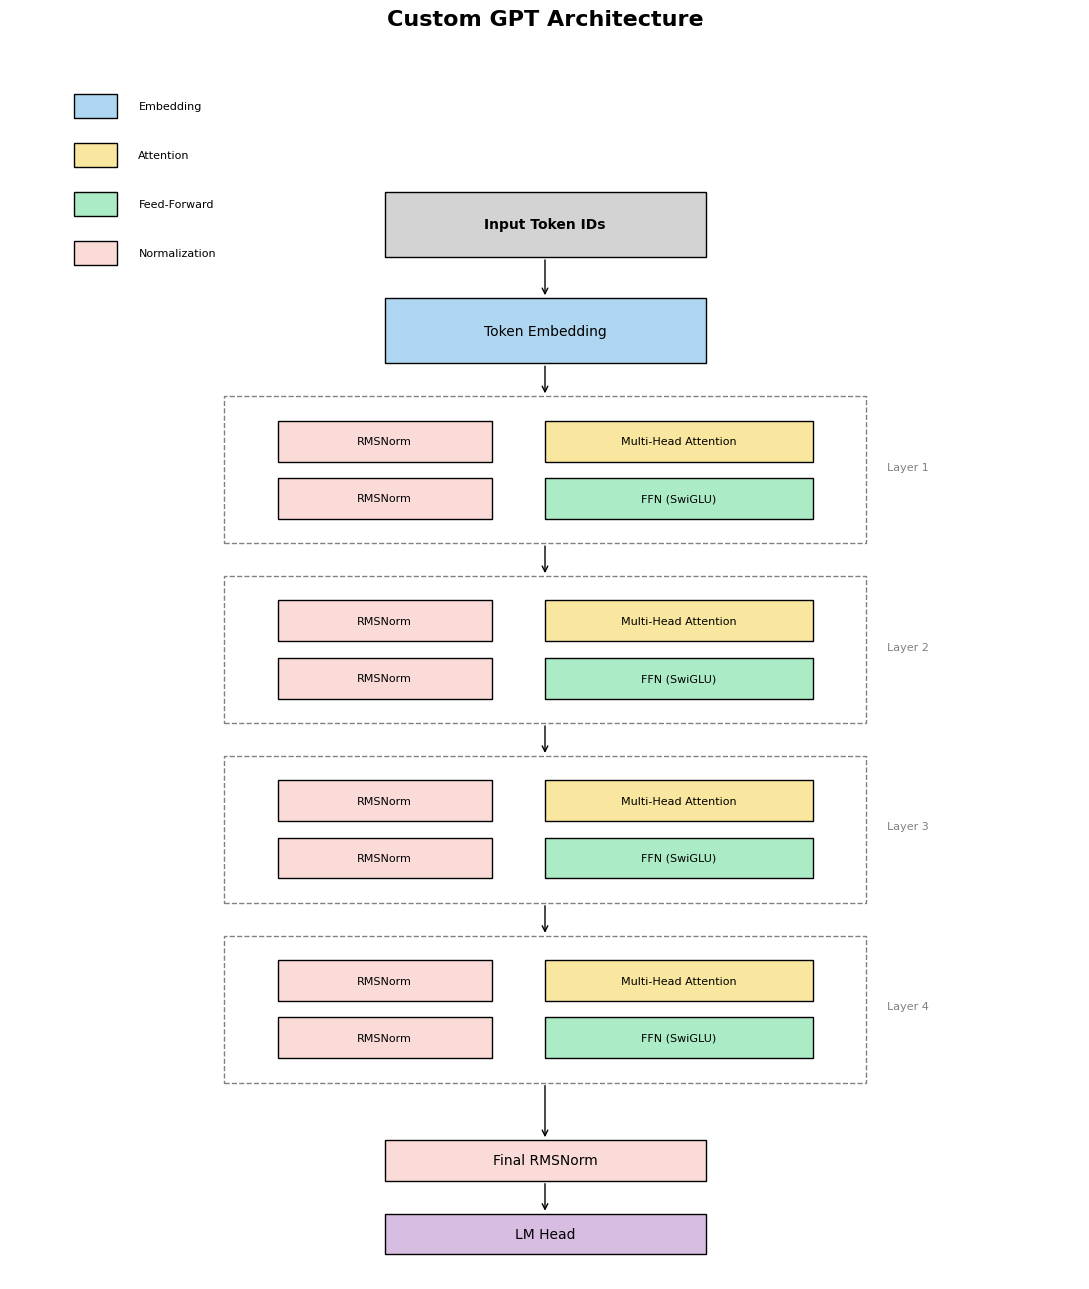

In [20]:
# 可视化模型架构
def visualize_architecture():
    fig, ax = plt.subplots(figsize=(11, 13))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 15)
    ax.axis('off')
    ax.set_title('Custom GPT Architecture', fontsize=16, fontweight='bold', pad=20)
    
    # 颜色定义
    embed_color = '#AED6F1'
    attn_color = '#F9E79F'
    ffn_color = '#ABEBC6'
    norm_color = '#FADBD8'
    output_color = '#D7BDE2'
    
    # 输入层
    ax.add_patch(plt.Rectangle((3.5, 12.5), 3, 0.8, color='lightgray', ec='black'))
    ax.text(5, 12.9, 'Input Token IDs', ha='center', va='center', fontsize=10, fontweight='bold')
    
    # Token Embedding
    ax.add_patch(plt.Rectangle((3.5, 11.2), 3, 0.8, color=embed_color, ec='black'))
    ax.text(5, 11.6, 'Token Embedding', ha='center', va='center', fontsize=10)
    ax.annotate('', xy=(5, 12.0), xytext=(5, 12.5), arrowprops=dict(arrowstyle='->', color='black'))
    
    # Transformer Blocks
    block_y = 9.3
    block_gap = 2.2
    first_block_top = block_y + 1.5
    ax.annotate('', xy=(5, first_block_top), xytext=(5, 11.2), arrowprops=dict(arrowstyle='->', color='black'))
    for i in range(4):
        y = block_y - i * block_gap
        
        # Block边框
        ax.add_patch(plt.Rectangle((2, y - 0.3), 6, 1.8, fill=False, ec='gray', linestyle='--'))
        ax.text(8.2, y + 0.6, f'Layer {i+1}', fontsize=8, color='gray')
        
        # RMSNorm + Attention
        ax.add_patch(plt.Rectangle((2.5, y + 0.7), 2, 0.5, color=norm_color, ec='black'))
        ax.text(3.5, y + 0.95, 'RMSNorm', ha='center', va='center', fontsize=8)
        
        ax.add_patch(plt.Rectangle((5, y + 0.7), 2.5, 0.5, color=attn_color, ec='black'))
        ax.text(6.25, y + 0.95, 'Multi-Head Attention', ha='center', va='center', fontsize=8)
        
        # RMSNorm + FFN
        ax.add_patch(plt.Rectangle((2.5, y), 2, 0.5, color=norm_color, ec='black'))
        ax.text(3.5, y + 0.25, 'RMSNorm', ha='center', va='center', fontsize=8)
        
        ax.add_patch(plt.Rectangle((5, y), 2.5, 0.5, color=ffn_color, ec='black'))
        ax.text(6.25, y + 0.25, 'FFN (SwiGLU)', ha='center', va='center', fontsize=8)
    
    # Arrows between blocks
    for i in range(3):
        upper_y = block_y - i * block_gap
        lower_y = block_y - (i + 1) * block_gap
        ax.annotate('', xy=(5, lower_y + 1.5), xytext=(5, upper_y - 0.3),
                    arrowprops=dict(arrowstyle='->', color='black'))
    
    # Final normalization
    ax.add_patch(plt.Rectangle((3.5, 1.2), 3, 0.5, color=norm_color, ec='black'))
    ax.text(5, 1.45, 'Final RMSNorm', ha='center', va='center', fontsize=10)
    last_block_bottom = block_y - 3 * block_gap - 0.3
    ax.annotate('', xy=(5, 1.7), xytext=(5, last_block_bottom), arrowprops=dict(arrowstyle='->', color='black'))
    
    # Output projection
    ax.add_patch(plt.Rectangle((3.5, 0.3), 3, 0.5, color=output_color, ec='black'))
    ax.text(5, 0.55, 'LM Head', ha='center', va='center', fontsize=10)
    ax.annotate('', xy=(5, 0.8), xytext=(5, 1.2), arrowprops=dict(arrowstyle='->', color='black'))
    
    # Legend
    legend_x = 0.6
    legend_y = 14.2
    legend_items = [
        (embed_color, 'Embedding'),
        (attn_color, 'Attention'),
        (ffn_color, 'Feed-Forward'),
        (norm_color, 'Normalization'),
    ]
    for i, (color, label) in enumerate(legend_items):
        y = legend_y - i * 0.6
        ax.add_patch(plt.Rectangle((legend_x, y), 0.4, 0.3, color=color, ec='black'))
        ax.text(legend_x + 0.6, y + 0.15, label, fontsize=8, va='center')
    
    plt.tight_layout()
    plt.show()

visualize_architecture()

## Part 2: 构建分词器

我们创建一个简单的字符/词级分词器：
1. 从训练文本构建词表
2. 将文本编码为token ID序列
3. 将token ID序列解码回文本

In [21]:
# 构建词表的示例文本
SAMPLE_TEXTS = [
    "机器学习是人工智能的一个重要分支。",
    "深度学习使用多层神经网络来学习数据表示。",
    "Transformer架构是现代NLP的基础。",
    "注意力机制让模型能够关注输入的不同部分。",
    "GPT是一种基于Transformer的生成式语言模型。",
    "预训练和微调是现代NLP的标准范式。",
    "梯度下降是训练神经网络的基本优化算法。",
    "反向传播使用链式法则计算参数梯度。",
    "正则化技术如Dropout可以防止过拟合。",
    "损失函数衡量模型预测和真实值的差异。",
] * 100  # 重复以获得更大词表

# 创建分词器（使用字符级，适合中文）
tokenizer = SimpleTokenizer(vocab_size=5000, mode="char", min_freq=1)
tokenizer.build_vocab(SAMPLE_TEXTS)

print(f"词表大小: {len(tokenizer)}")
print(f"\n部分词表内容:")
for token, idx in list(tokenizer.token_to_id.items())[:15]:
    print(f"  '{token}' -> {idx}")

Vocabulary built: 127 tokens
词表大小: 127

部分词表内容:
  '<PAD>' -> 0
  '<BOS>' -> 1
  '<EOS>' -> 2
  '<UNK>' -> 3
  '。' -> 4
  '的' -> 5
  'r' -> 6
  '是' -> 7
  'o' -> 8
  '学' -> 9
  '习' -> 10
  '度' -> 11
  '数' -> 12
  'T' -> 13
  'P' -> 14


In [22]:
# 测试编码和解码
test_text = "深度学习是人工智能的核心技术。"

# 编码
encoded = tokenizer.encode(test_text, add_bos=True, add_eos=True)
print(f"原文: {test_text}")
print(f"编码: {encoded}")

# 解码
decoded = tokenizer.decode(encoded, skip_special=True)
print(f"解码: {decoded}")

# 带填充的编码
encoded_padded = tokenizer.encode(test_text, max_length=30, padding=True)
print(f"\n填充到长度30: {encoded_padded}")

原文: 深度学习是人工智能的核心技术。
编码: [1, 57, 11, 9, 10, 7, 50, 51, 52, 20, 5, 3, 3, 102, 103, 4, 2]
解码: 深度学习是人工智能的技术。

填充到长度30: [1, 57, 11, 9, 10, 7, 50, 51, 52, 20, 5, 3, 3, 102, 103, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Part 3: 测试模型

验证模型的前向传播、损失计算和生成功能正常工作。

In [23]:
# 测试前向传播
print("测试前向传播")
print("=" * 50)

batch_size = 4
seq_len = 32

# 随机输入
input_ids = torch.randint(0, config.vocab_size, (batch_size, seq_len)).to(device)

# 前向传播
model.eval()
with torch.no_grad():
    outputs = model(input_ids)

print(f"输入形状: {input_ids.shape}")
print(f"输出logits形状: {outputs['logits'].shape}")
print(f"期望: [batch_size, seq_len, vocab_size] = [{batch_size}, {seq_len}, {config.vocab_size}]")

测试前向传播
输入形状: torch.Size([4, 32])
输出logits形状: torch.Size([4, 32, 5000])
期望: [batch_size, seq_len, vocab_size] = [4, 32, 5000]


In [24]:
# 测试带标签的训练模式
print("\n测试训练模式 (带loss计算)")
print("=" * 50)

# 标签 = 下一个token（用于next-token prediction）
labels = torch.randint(0, config.vocab_size, (batch_size, seq_len)).to(device)

model.train()
outputs = model(input_ids, labels=labels)

print(f"Loss: {outputs['loss'].item():.4f}")
print(f"初始loss期望值 ~ ln(vocab_size) = {np.log(config.vocab_size):.4f}")


测试训练模式 (带loss计算)
Loss: 8.5520
初始loss期望值 ~ ln(vocab_size) = 8.5172


In [25]:
# 测试Attention Mask（处理padding）
print("\n测试Attention Mask")
print("=" * 50)

# 创建带padding的输入
input_ids = torch.tensor([
    tokenizer.encode("深度学习", max_length=20, padding=True),
    tokenizer.encode("机器学习是人工智能", max_length=20, padding=True),
]).to(device)

# 创建attention mask (1=关注, 0=忽略)
attention_mask = (input_ids != tokenizer.pad_token_id).float()

print(f"输入IDs:\n{input_ids}")
print(f"\nAttention Mask:\n{attention_mask}")

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

print(f"\n输出形状: {outputs['logits'].shape}")


测试Attention Mask
输入IDs:
tensor([[ 1, 57, 11,  9, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0],
        [ 1, 19, 49,  9, 10,  7, 50, 51, 52, 20,  2,  0,  0,  0,  0,  0,  0,  0,
          0,  0]], device='cuda:0')

Attention Mask:
tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]], device='cuda:0')

输出形状: torch.Size([2, 20, 5000])


In [26]:
# 测试文本生成
print("\n测试文本生成")
print("=" * 50)

# 编码prompt
prompt = "深度学习"
prompt_ids = torch.tensor([tokenizer.encode(prompt, add_bos=True, add_eos=False)]).to(device)

print(f"Prompt: '{prompt}'")
print(f"Prompt IDs: {prompt_ids.tolist()[0]}")

# 生成（注意：模型未训练，输出会是随机的）
model.eval()
generated_ids = model.generate(
    prompt_ids,
    max_new_tokens=20,
    temperature=1.0,
    top_k=50,
    do_sample=True
)

print(f"生成IDs: {generated_ids.tolist()[0]}")

# 解码
generated_text = tokenizer.decode(generated_ids.tolist()[0])
print(f"生成文本: '{generated_text}'")
print("\n(注意: 模型尚未训练，所以输出是随机的)")


测试文本生成
Prompt: '深度学习'
Prompt IDs: [1, 57, 11, 9, 10]
生成IDs: [1, 57, 11, 9, 10, 1836, 856, 2515, 1836, 4300, 1068, 4238, 2656, 4238, 3702, 2442, 1578, 1114, 1836, 2256, 1927, 2991, 370, 2442, 2073]
生成文本: '深度学习'

(注意: 模型尚未训练，所以输出是随机的)


## Part 4: 快速过拟合测试

验证模型能够学习，通过在一个小数据集上过拟合。

In [27]:
# 创建一个小数据集用于过拟合
train_text = "深度学习是人工智能的核心技术。"
train_ids = tokenizer.encode(train_text, add_bos=True, add_eos=True)

# 转换为tensors
train_input = torch.tensor([train_ids[:-1]]).to(device)   # 输入
train_labels = torch.tensor([train_ids[1:]]).to(device)   # 标签（右移1位）

print(f"训练文本: '{train_text}'")
print(f"输入: {train_input.tolist()[0]}")
print(f"标签: {train_labels.tolist()[0]}")

训练文本: '深度学习是人工智能的核心技术。'
输入: [1, 57, 11, 9, 10, 7, 50, 51, 52, 20, 5, 3, 3, 102, 103, 4]
标签: [57, 11, 9, 10, 7, 50, 51, 52, 20, 5, 3, 3, 102, 103, 4, 2]


In [28]:
# 训练几步
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()

losses = []
print("训练（在单句上过拟合）:")
print("-" * 40)

for step in range(100):
    outputs = model(train_input, labels=train_labels)
    loss = outputs['loss']
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if step % 20 == 0:
        print(f"Step {step:3d} | Loss: {loss.item():.4f}")

print(f"\n最终loss: {losses[-1]:.4f}")
print("模型成功学习了！(loss下降)")

训练（在单句上过拟合）:
----------------------------------------
Step   0 | Loss: 8.6536
Step  20 | Loss: 0.5767
Step  40 | Loss: 0.0563
Step  60 | Loss: 0.0263
Step  80 | Loss: 0.0196

最终loss: 0.0732
模型成功学习了！(loss下降)


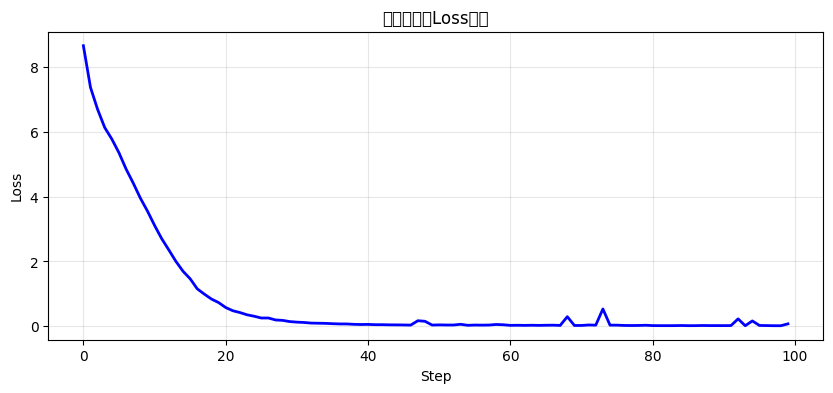

In [29]:
# 绘制训练loss
plt.figure(figsize=(10, 4))
plt.plot(losses, 'b-', linewidth=2)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('过拟合训练Loss曲线')
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
# 测试训练后的生成
model.eval()
prompt_ids = torch.tensor([tokenizer.encode("深度学习", add_bos=True, add_eos=False)]).to(device)

generated_ids = model.generate(
    prompt_ids,
    max_new_tokens=15,
    temperature=0.5,
    top_k=10,
    do_sample=True
)

print(f"Prompt: '深度学习'")
print(f"生成: '{tokenizer.decode(generated_ids.tolist()[0])}'")
print(f"\n期望输出: '深度学习是人工智能的核心技术。'")

Prompt: '深度学习'
生成: '深度学习人智的技。术工能技。术。术'

期望输出: '深度学习是人工智能的核心技术。'


## Part 5: 保存模型和分词器

保存到 `models/custom_gpt` 目录，供后续 notebook 使用。

In [31]:
# 保存路径
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "models", "custom_gpt")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# 重置模型为未训练状态
fresh_model = CustomGPT(config)

# 保存初始（未训练）模型
fresh_model.save_pretrained(os.path.join(CHECKPOINT_DIR, "base_model"))

# 保存分词器
tokenizer.save(os.path.join(CHECKPOINT_DIR, "tokenizer.pkl"))

print("保存完成:")
print(f"  - 模型: {CHECKPOINT_DIR}/base_model/")
print(f"  - 分词器: {CHECKPOINT_DIR}/tokenizer.pkl")

Model saved to c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\base_model
保存完成:
  - 模型: c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt/base_model/
  - 分词器: c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt/tokenizer.pkl


In [32]:
# 验证加载功能
loaded_model = CustomGPT.from_pretrained(os.path.join(CHECKPOINT_DIR, "base_model"))
loaded_tokenizer = SimpleTokenizer.load(os.path.join(CHECKPOINT_DIR, "tokenizer.pkl"))

print("成功加载模型和分词器!")
print(f"模型参数: {count_parameters(loaded_model)}")
print(f"分词器词表大小: {len(loaded_tokenizer)}")

Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\base_model
成功加载模型和分词器!
模型参数: 3.90M
分词器词表大小: 127


## 总结

### 本notebook完成的内容

1. **自建GPT模型** (~12.6M参数)
   - RoPE位置编码
   - RMSNorm归一化
   - SwiGLU激活函数
   - Pre-norm架构

2. **简单分词器**
   - 字符/词级分词
   - 特殊token (PAD, BOS, EOS, UNK)
   - 保存/加载支持

3. **功能验证**
   - 前向传播正常
   - 损失计算正常
   - 模型能够学习（过拟合测试）
   - 文本生成正常

### 下一步: 预训练 (02_Pretraining.ipynb)

在下一个notebook中，我们将对模型进行预训练：
- 使用文本语料进行next-token prediction
- 让模型学习语言的统计规律